# Μια εισαγωγή στους Variational Autoencoders (VAE)

In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [10]:
# Model Hyperparameters

dataset_path = '~/datasets'
#cuda = True
#DEVICE = torch.device("cuda" if cuda else "cpu")
batch_size = 100
x_dim  = 784
hidden_dim = 400
latent_dim = 200
lr = 1e-3
epochs = 30

### Κατεβάζουμε το MNIST

In [4]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True}

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 9.91M/9.91M [00:00<00:00, 52.5MB/s]


Extracting /root/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.14MB/s]

Extracting /root/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 1.65M/1.65M [00:00<00:00, 15.2MB/s]


Extracting /root/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.74MB/s]

Extracting /root/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



### Ορισμός του μοντέλου (δίκτυο Encoder και δίκτυο Decoder)

In [6]:

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True

    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)
        return mean, log_var

In [11]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat


In [12]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        #epsilon = torch.randn_like(var).to(DEVICE)
        epsilon = torch.randn_like(var)
        z = mean + var * epsilon
        return z

    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat            = self.Decoder(z)
        return x_hat, mean, log_var

In [13]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

#model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)
model = Model(Encoder=encoder, Decoder=decoder)

### Define Loss function (reprod. loss) and optimizer

In [14]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

### Training

In [15]:
print("Έναρξη εκπαίδευσης VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        #x = x.to(DEVICE)

        optimizer.zero_grad()
        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        overall_loss += loss.item()
        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))


Έναρξη εκπαίδευσης VAE...
	Epoch 1 complete! 	Average Loss:  172.8648746119835
	Epoch 2 complete! 	Average Loss:  128.4880951325125
	Epoch 3 complete! 	Average Loss:  117.57422222258451
	Epoch 4 complete! 	Average Loss:  113.2254349371348
	Epoch 5 complete! 	Average Loss:  110.361495819856
	Epoch 6 complete! 	Average Loss:  108.58590156771703
	Epoch 7 complete! 	Average Loss:  107.23685137664336
	Epoch 8 complete! 	Average Loss:  106.04840742057074
	Epoch 9 complete! 	Average Loss:  105.28714578007617
	Epoch 10 complete! 	Average Loss:  104.58015590763252
	Epoch 11 complete! 	Average Loss:  104.07116144094324
	Epoch 12 complete! 	Average Loss:  103.67280974475689
	Epoch 13 complete! 	Average Loss:  103.3153397589733
	Epoch 14 complete! 	Average Loss:  102.94613659484557
	Epoch 15 complete! 	Average Loss:  102.71422567886582
	Epoch 16 complete! 	Average Loss:  102.36399027676336
	Epoch 17 complete! 	Average Loss:  102.1673892522694
	Epoch 18 complete! 	Average Loss:  101.92617192390964


### Προβολή εικόνων του test set στον λανθάνον χώρο + επανασύσταση (x -> z -> x')

In [16]:
import matplotlib.pyplot as plt

In [38]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        #x = x.to(DEVICE)
        x_hat, _, _ = model(x)
        break

  0%|          | 0/100 [00:00<?, ?it/s]


In [18]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)
    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

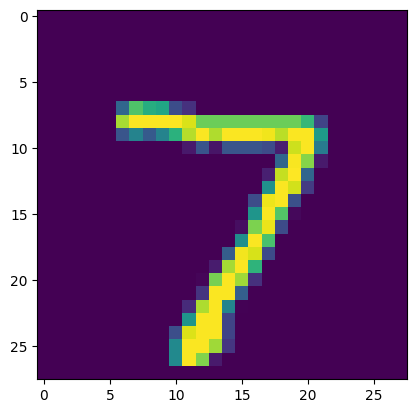

In [19]:
show_image(x, idx=0)

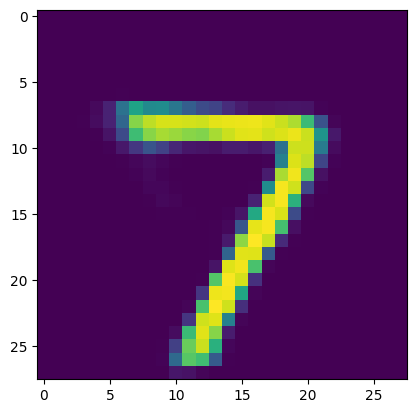

In [20]:
show_image(x_hat, idx=0)

### Επίδειξη δυνατοτήτων αφαίρεσης θορύβου

torch.Size([784])


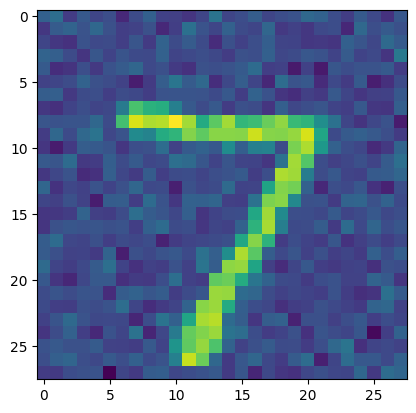

In [48]:
x0 = x[0, :]
print(x0.shape)
x0 = x0 + 0.1*torch.randn(784)
plt.imshow(torch.squeeze(x0.view(28, 28)).cpu().detach().numpy())

torch.Size([1, 28, 28])


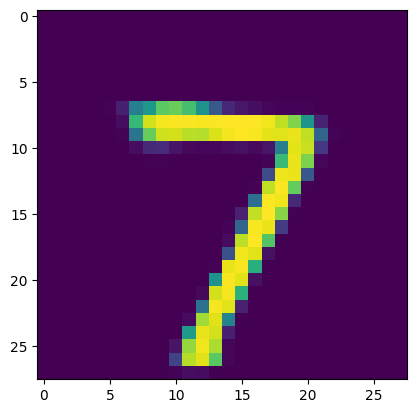

In [49]:
xh, _, _ = model(x0)
xh = xh.view(1, 28, 28)
print(xh.shape)
plt.imshow(torch.squeeze(xh).cpu().detach().numpy())

### Παραγωγή νέας εικόνας με δειγματοληψία στον λανθάνον χώρο (z -> x')

In [21]:
with torch.no_grad():
    #noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    noise = torch.randn(batch_size, latent_dim)
    generated_images = decoder(noise)

In [22]:
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

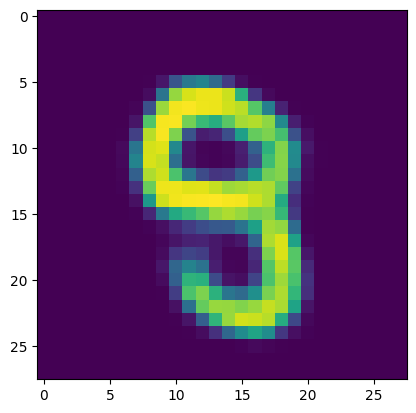

In [24]:
show_image(generated_images, idx=0)